# Session 4 - Resampling Methods

## Content

- [Cross-Validation](#Cross-Validation)
- [The Bootstrap](#The-Bootstrap)

## Labs

- [Cross-Validation and the Bootstrap](#Lab-1:-Cross-Validation-and-the-Bootstrap)

In [25]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import time

from numpy.linalg import inv
from numpy.random import normal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

In [26]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Cross-Validation

For this exercise we are going to use the car dataset.

In [27]:
# Load car dataset
df1 = pd.read_csv('data/Auto.csv', na_values='?').dropna()
df1.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


### The Validation Set Approach

Suppose that we would like to estimate the test error associated with fit- ting a particular statistical learning method on a set of observations. The validation set approach is a very simple strategy for this task. It involves randomly dividing the available set of observations into two parts

1. a **training set** and 
2. a **validation set** or hold-out set

The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate-typically assessed using MSE in the case of a quantitative response—provides an estimate of the test error rate.

In the following example we are are going to compute the MSE fit polynomial of different order (one to ten).

In [28]:
# Cross-validation function for polynomials
def cv_poly(X, y, p_order, r_states, t_prop):
    start = time.time()
    
    # Init scores
    scores = np.zeros((p_order.size,r_states.size))
    
    # For every polynomial degree
    for i in p_order:
        # Generate 10 random splits of the dataset
        for j in r_states:

            # Generate polynomial
            X_poly = PolynomialFeatures(i+1).fit_transform(X)

            # Split sample in train and test
            X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=t_prop)

            # Fit regression                                                                    
            ols = LinearRegression().fit(X_train, y_train)
            pred = ols.predict(X_test)
            scores[i,j]= mean_squared_error(y_test, pred)
    print('Time elapsed: %.4f seconds' % (time.time()-start))
    return scores

In [29]:
# Init
t_prop = 0.5
p_order = np.arange(10)
r_states = np.arange(10)

# Get X,y 
X = df1.horsepower.values.reshape(-1,1)
y = df1.mpg.ravel()

# Compute scores
cv_scores = cv_poly(X, y, p_order, r_states, t_prop)

Time elapsed: 0.3450 seconds


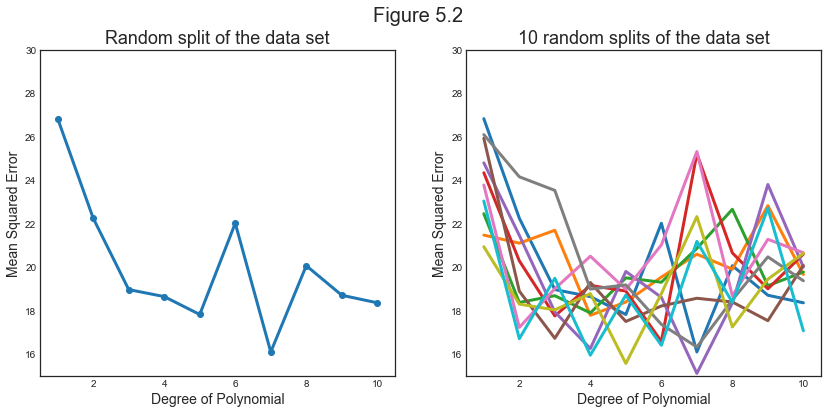

In [31]:
# Figure 5.2
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
fig.suptitle('Figure 5.2')

# Left plot (first split)
ax1.plot(p_order+1,cv_scores[:,0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(p_order+1,cv_scores)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

This figure illustrates a **first drawback** of the validation approach: the estimate of the test error rate can be highly variable, depending on pre- cisely which observations are included in the training set and which observations are included in the validation set.


The **second drawback** of the validation approach is that only a subset of the observations—those that are included in the training set rather than in the validation set—are used to fit the model. Since statistical methods tend to per- form worse when trained on fewer observations, this suggests that the validation set error rate may tend to overestimate the test error rate for the model fit on the entire data set.

### Leave-One-Out Cross-Validation

Leave-one-out cross-validation (LOOCV) ttempts to address that method’s drawbacks.

Like the validation set approach, LOOCV involves splitting the set of observations into two parts. However, instead of creating two subsets of comparable size, a single observation $i$ is used for the validation set, and the remaining $n-1$ observations make up the training set. The statistical learning method is fit on the $n−1$ training observations and the MSE is computed using the excluded observation $i$. The procedure is repeated $n$ times, for $i=1,...,n$.

The LOOCV estimate for the test MSE is the average of these $n$ test error estimates:

$$
\mathrm{CV}_{(n)}=\frac{1}{n} \sum_{i=1}^{n} \mathrm{MSE}_{i}
$$

LOOCV has a couple of major **advantages** over the validation set approach. 

First, it has far less bias. In LOOCV, we repeatedly fit the statistical learning method using training sets that contain $n − 1$ observations, almost as many as are in the entire data set. However, this also means that LOOCV is more computationally intense.

Second, in contrast to the validation approach which will yield different results when applied repeatedly due to randomness in the training/validation set splits, performing LOOCV multiple times will always yield the same results: there is no randomness in the training/validation set splits.

In [32]:
# LeaveOneOut CV function for polynomials
def loo_cv_poly(X, y, p_order):
    start = time.time()
    
    # Init
    loo = LeaveOneOut().get_n_splits(y)
    loo_scores = np.zeros((p_order.size,1))
    
    # For every polynomial degree
    for i in p_order:
        # Generate polynomial
        X_poly = PolynomialFeatures(i+1).fit_transform(X)

        # Get score
        loo_scores[i] = cross_val_score(LinearRegression(), X_poly, y, cv=loo, scoring='neg_mean_squared_error').mean()
        
    print('Time elapsed: %.4f seconds' % (time.time()-start))
    return loo_scores

In [38]:
# Validation set approach
cv_scores = cv_poly(X, y, p_order, r_states, t_prop)
    
# Leave One Out CV
loo_scores = loo_cv_poly(X, y, p_order)

Time elapsed: 0.2519 seconds
Time elapsed: 5.4084 seconds


As expected, LOOCV is much more computationally intense. Even accounting for the fact that we repeat every the validation set approach 10 times.

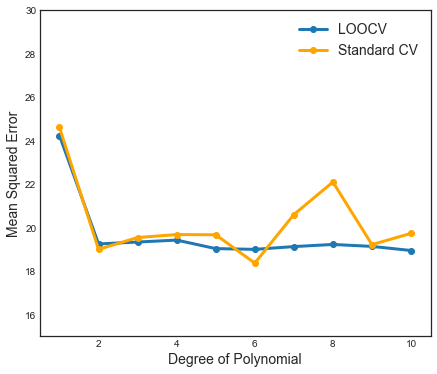

In [39]:
fig, ax = plt.subplots(1,1, figsize=(7,6))

# Left plot
ax.plot(p_order+1, np.array(loo_scores)*-1, '-o', label='LOOCV')
ax.plot(p_order+1, np.mean(cv_scores, axis=1), '-o', c='orange', label='Standard CV')
ax.set_ylabel('Mean Squared Error'); ax.set_xlabel('Degree of Polynomial');
ax.set_ylim(15,30); ax.set_xlim(0.5,10.5);
ax.set_xticks(range(2,11,2));
ax.legend();

With least squares linear or polynomial regression, an amazing shortcut makes the cost of LOOCV the same as that of a single model fit! The following formula holds:

$$
\mathrm{CV}_{(n)}=\frac{1}{n} \sum_{i=1}^{n}\left(\frac{y_{i}-\hat{y}_{i}}{1-h_{i}}\right)^{2}
$$

where $\hat y_i$ is the $i^{th}$ fitted value from the original least squares fit, and $h_i$ is the leverage of observation $i$.

### k-Fold Cross-Validation

An alternative to LOOCV is k-fold CV. This approach involves the following steps:

1. Randomly dividing the set of observations into $k$ groups, or folds, of approximately equal size.
2. The first fold is treated as a validation set, and the method is fit on the remaining $k − 1$ folds. 
3. The mean squared error, MSE1, is then computed on the observations in the held-out fold.
4. Steps (1)-(3) are repeated $k$ times; each time, a different group of observations is treated as a validation set.

The k-fold CV estimate is computed by averaging these values

$$
\mathrm{CV}_{(k)}=\frac{1}{k} \sum_{i=1}^{k} \mathrm{MSE}_{i}
$$

LOOCV is a special case of k-fold CV in which $k$ is set to equal $n$. In practice, one typically performs k-fold CV using $k = 5$ or $k = 10$.

The most obvious **advantage** is computational. LOOCV requires fitting the statistical learning method $n$ times, while k-fold CV only requires $k$ splits. 

In [35]:
# 10fold CV function for polynomials
def k10_cv_poly(X, y, p_order, r_states, folds):
    start = time.time()
    
    # Init
    k10_scores = np.zeros((p_order.size,r_states.size))

    # Generate 10 random splits of the dataset
    for j in r_states:

        # For every polynomial degree
        for i in p_order:

            # Generate polynomial
            X_poly = PolynomialFeatures(i+1).fit_transform(X)

            # Split sample in train and test
            kf10 = KFold(n_splits=folds, shuffle=True, random_state=j)
            k10_scores[i,j] = cross_val_score(LinearRegression(), X_poly, y, cv=kf10, 
                                               scoring='neg_mean_squared_error').mean()  
    
    print('Time elapsed: %.4f seconds' % (time.time()-start))
    return k10_scores

In [36]:
# Leave One Out CV
loo_scores = loo_cv_poly(X, y, p_order)
    
# 10-fold CV
folds = 10
k10_scores = k10_cv_poly(X, y, p_order, r_states, folds)

Time elapsed: 6.1230 seconds
Time elapsed: 1.5633 seconds


Indeed we see that the LOOCV approach is more computationally intense. Even accounting for the fact that we repeat every 10-fold cross-validation 10 times.

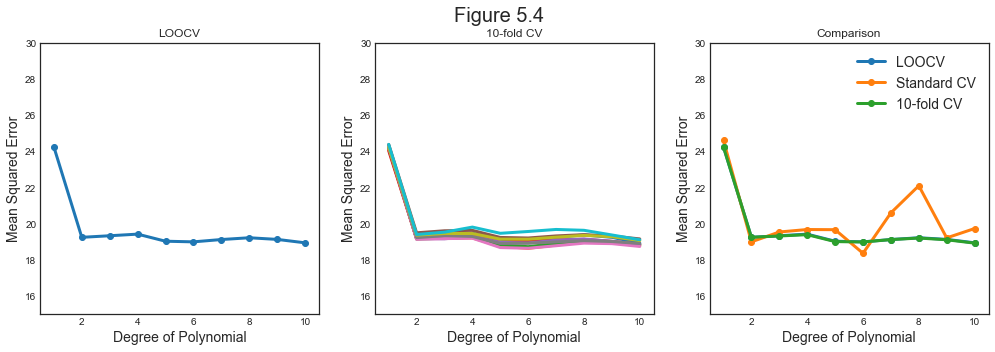

In [48]:
# Figure 5.4
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(17,5))
fig.suptitle('Figure 5.4')

# Left plot
ax1.plot(p_order+1, np.array(loo_scores)*-1, '-o')
ax1.set_title('LOOCV', fontsize=12)

# Center plot
ax2.plot(p_order+1,k10_scores*-1)
ax2.set_title('10-fold CV', fontsize=12)

# Right plot
ax3.plot(p_order+1, np.array(loo_scores)*-1, '-o', label='LOOCV')
ax3.plot(p_order+1, np.mean(cv_scores, axis=1), '-o', label='Standard CV')
ax3.plot(p_order+1,np.mean(k10_scores,axis=1)*-1, '-o', label='10-fold CV')
ax3.set_title('Comparison', fontsize=12);
ax3.legend();

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

10-fold cross-validation outputs a very similar MSE with respect to LOOCV, but with considerably less computational time.

## The Bootstrap

The bootstrap is a widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method. In the specific case of linear regression, this is not particularly useful since there exist a formula for the standard errors. However, there are many models (almost all actually) for which there exists no closed for solution to the estimator variance.

In pricinple, we would like to draw independent samples from the true data generating process and assessing the uncertainty of an estimator by comparing its values across the different samples. However, this is clearly unfeasible since we do not know the true data generating process.

With the bootstrap, rather than repeatedly obtaining independent data sets from the population, we instead obtain distinct data sets by repeatedly sampling observations from the original data set. The power of the bootstrap lies in the fact that it can be easily applied to a wide range of statistical learning methods, including some for which a measure of variability is otherwise difficult to obtain and is not automatically output by statistical software.

We are now going to assess its usefulness through simulation. Take the following model:

$$
y_i = \beta_0 \cdot x_i + \varepsilon_i
$$

where $\beta_0 = 0.6$ and $\varepsilon \sim N(0,1)$. We are now going to assess the variance of the OLS estimator $\hat \beta$ with the standard formula, simulating different samples and with bootstrap.

In [13]:
# Set seed
np.random.seed(1)

# Init
simulations = 1000
N = 1000
beta_0 = 0.6
beta_sim = np.zeros((simulations,1))

# Generate X
X = normal(0,3,N).reshape(-1,1)

# Loop over simulations
for i in range(simulations):
    
    # Generate y
    e = normal(0,1,N).reshape(-1,1)
    y = beta_0*X + e
    
    # Estimate beta OLS
    beta_sim[i] = inv(X.T @ X) @ X.T @ y

In [14]:
# Init Bootstrap
beta_boot = np.zeros((simulations,1))

# Loop over simulations
for i in range(simulations):
    
    # Sample y
    X_sample, y_sample = resample(X, y, random_state=i)
    
    # Estimate beta OLS
    beta_boot[i] = inv(X_sample.T @ X_sample) @ X_sample.T @ y_sample

We can first compare the means.

In [15]:
# Print means
print('True value      : %.4f' % beta_0)
print('Mean Simulations: %.4f' % np.mean(beta_sim))
print('Mean One Sample : %.4f' % beta_sim[-1])
print('Mean Boostrap   : %.4f' % np.mean(beta_boot))

True value      : 0.6000
Mean Simulations: 0.6003
Mean One Sample : 0.5815
Mean Boostrap   : 0.5816


The mean of the bootstrap estimtor is quite off. But this is not its actual purpose: it is designed to assess the uncertainty of an estimator, not its value.

Now we compare the variances.

In [16]:
# Print variances
print('True std       : %.6f' % np.sqrt(inv(X.T @ X)))
print('Std Simulations: %.6f' % np.std(beta_sim))
print('Std One Sample : %.6f' % np.sqrt(inv(X.T @ X) * np.var(y - beta_sim[-1]*X)))
print('Std Boostrap   : %.6f' % np.std(beta_boot))

True std       : 0.010737
Std Simulations: 0.010830
Std One Sample : 0.010536
Std Boostrap   : 0.010812


Bootstrap gets as close to the true standard deviation of the estimator as the simulation with the true data generating process. Impressive!

We can now have a visual inspection.

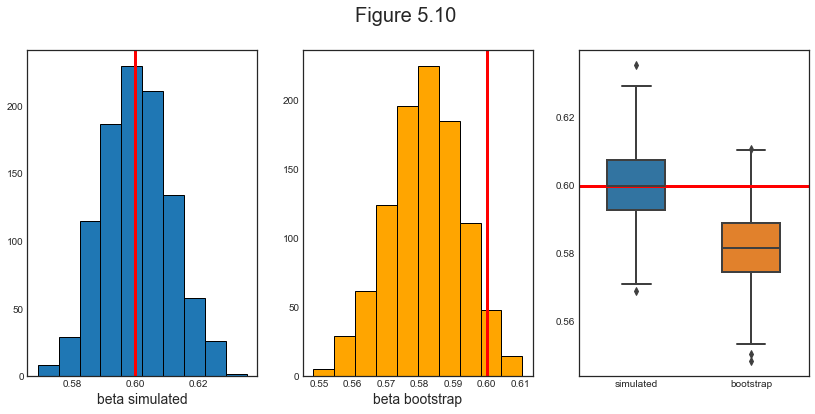

In [18]:
# Figure 5.10
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,6))
fig.suptitle('Figure 5.10')

# Left plot
ax1.hist(beta_sim, bins=10, edgecolor='black');
ax1.axvline(x=beta_0, color='r', label='beta_0')
ax1.set_xlabel('beta simulated');

# Center plot
ax2.hist(beta_boot, bins=10, color='orange', edgecolor='black');
ax2.axvline(x=beta_0, color='r', label='beta_0')
ax2.set_xlabel('beta bootstrap');

# Right plot
df_bootstrap = pd.DataFrame({'simulated': beta_sim.ravel(), 'bootstrap':beta_boot.ravel()}, 
                            index=range(simulations))
ax3 = sns.boxplot(data=df_bootstrap, width=0.5, linewidth=2);
ax3.axhline(y=beta_0, color='r', label='beta_0');

As we can see, the bootstrap is a powerful tool to assess the uncertainty of an estimator.

# Labs

## Lab 1: Cross-Validation and the Bootstrap

### Lab 1.1: The Validation Set Approach

In this section, we'll explore the use of the validation set approach in order to estimate the
test error rates that result from fitting various linear models on the ${\tt Auto}$ data set.

In [ ]:
df1 = pd.read_csv('Auto.csv', na_values='?').dropna()
df1.info()

We begin by using the ${\tt sample()}$ function to split the set of observations
into two halves, by selecting a random subset of 196 observations out of
the original 392 observations. We refer to these observations as the training
set.

We'll use the ${\tt random\_state}$ parameter in order to set a seed for
${\tt python}$’s random number generator, so that you'll obtain precisely the same results each time. It is generally a good idea to set a random seed when performing an analysis such as cross-validation
that contains an element of randomness, so that the results obtained can be reproduced precisely at a later time.

In [ ]:
train_df = df1.sample(196, random_state = 1)
test_df = df1[~df1.isin(train_df)].dropna(how = 'all')

X_train = train_df['horsepower'].values.reshape(-1,1)
y_train = train_df['mpg']
X_test = test_df['horsepower'].values.reshape(-1,1)
y_test = test_df['mpg']

We then use ${\tt LinearRegression()}$ to fit a linear regression to predict ${\tt mpg}$ from ${\tt horsepower}$ using only
the observations corresponding to the training set.

In [ ]:
lm = skl_lm.LinearRegression()
model = lm.fit(X_train, y_train)

We now use the ${\tt predict()}$ function to estimate the response for the test
observations, and we use ${\tt sklearn}$ to caclulate the MSE.

In [ ]:
pred = model.predict(X_test)
MSE = mean_squared_error(y_test, pred)
    
print(MSE)

Therefore, the estimated test MSE for the linear regression fit is 23.36. We
can use the ${\tt PolynomialFeatures()}$ function to estimate the test error for the polynomial
and cubic regressions.

In [ ]:
# Quadratic
poly = PolynomialFeatures(degree=2)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)

model = lm.fit(X_train2, y_train)
print(mean_squared_error(y_test, model.predict(X_test2)))

# Cubic
poly = PolynomialFeatures(degree=3)
X_train3 = poly.fit_transform(X_train)
X_test3 = poly.fit_transform(X_test)

model = lm.fit(X_train3, y_train)
print(mean_squared_error(y_test, model.predict(X_test3)))

These error rates are 20.25 and 20.33, respectively. If we choose a different
training set instead, then we will obtain somewhat different errors on the
validation set. We can test this out by setting a different random seed:

In [ ]:
train_df = df1.sample(196, random_state = 2)
test_df = df1[~df1.isin(train_df)].dropna(how = 'all')

X_train = train_df['horsepower'].values.reshape(-1,1)
y_train = train_df['mpg']
X_test = test_df['horsepower'].values.reshape(-1,1)
y_test = test_df['mpg']

# Linear
model = lm.fit(X_train, y_train)
print(mean_squared_error(y_test, model.predict(X_test)))

# Quadratic
poly = PolynomialFeatures(degree=2)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)

model = lm.fit(X_train2, y_train)
print(mean_squared_error(y_test, model.predict(X_test2)))

# Cubic
poly = PolynomialFeatures(degree=3)
X_train3 = poly.fit_transform(X_train)
X_test3 = poly.fit_transform(X_test)

model = lm.fit(X_train3, y_train)
print(mean_squared_error(y_test, model.predict(X_test3)))

Using this split of the observations into a training set and a validation
set, we find that the validation set error rates for the models with linear,
quadratic, and cubic terms are 25.11, 19.72, and 19.92, respectively.

These results are consistent with our previous findings: a model that
predicts ${\tt mpg}$ using a quadratic function of ${\tt horsepower}$ performs better than
a model that involves only a linear function of ${\tt horsepower}$, and there is
little evidence in favor of a model that uses a cubic function of ${\tt horsepower}$.

### Lab 1.2:  Leave-One-Out Cross-Validation

The LOOCV estimate can be automatically computed for any generalized linear model using the `LeaveOneOut()` and `KFold()` functions.

In [ ]:
# Model
model = lm.fit(X_train, y_train)

# Leave one out
loo = LeaveOneOut()
X = df1['horsepower'].values.reshape(-1,1)
y = df1['mpg'].values.reshape(-1,1)
loo.get_n_splits(X)

# Cross-validation
crossvalidation = KFold(n_splits=392, random_state=None, shuffle=False)
scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=crossvalidation,
 n_jobs=1)

# Print
print("Folds: " + str(len(scores)) + ", MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Our cross-validation estimate for the test error is approximately 24.23. We can repeat this procedure for increasingly complex polynomial fits.
To automate the process, we use the `for()` function to initiate a for loop
which iteratively fits polynomial regressions for polynomials of order `i = 1`
to `i = 5` and computes the associated cross-validation error. 

This command may take a couple of minutes to run.

In [ ]:
# Loop
for i in range(1,6):
    poly = PolynomialFeatures(degree=i)
    X_current = poly.fit_transform(X)
    model = lm.fit(X_current, y)
    scores = cross_val_score(model, X_current, y, scoring="neg_mean_squared_error", cv=crossvalidation,
 n_jobs=1)
    
    print("Degree-"+str(i)+" polynomial MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Here we see a sharp drop in the estimated test MSE between
the linear and quadratic fits, but then no clear improvement from using
higher-order polynomials.

### Lab 1.3: k-Fold Cross-Validation

The `KFold` function can (intuitively) also be used to implement `k`-fold CV. Below we
use `k = 10`, a common choice for `k`, on the `Auto` data set. We once again set
a random seed and initialize a vector in which we will print the CV errors
corresponding to the polynomial fits of orders one to ten.

In [ ]:
crossvalidation = KFold(n_splits=10, random_state=1, shuffle=False)

# Loop
for i in range(1,11):
    poly = PolynomialFeatures(degree=i)
    X_current = poly.fit_transform(X)
    model = lm.fit(X_current, y)
    scores = cross_val_score(model, X_current, y, scoring="neg_mean_squared_error", cv=crossvalidation,
 n_jobs=1)
    
    print("Degree-"+str(i)+" polynomial MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Notice that the computation time is **much** shorter than that of LOOCV.
(In principle, the computation time for LOOCV for a least squares linear
model should be faster than for `k`-fold CV, due to the availability of the
formula (5.2) for LOOCV; however, unfortunately the `KFold()` function
does not make use of this formula.) We still see little evidence that using
cubic or higher-order polynomial terms leads to lower test error than simply
using a quadratic fit.

#### An Application to Default Data

Now that you're armed with more useful technique for resampling your data, let's try fitting a model for the `Default` dataset:

In [ ]:
# Load default dataset
df2 = pd.read_csv('Default.csv', na_values='?').dropna()
df2.describe()

First we'll try just holding out a random 20% of the data:

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report

for i in range(1,11):
    train_df2 = df2.sample(8000, random_state = i)
    test_df2 = df2[~df2.isin(train_df2)].dropna(how = 'all')
    
    # Fit a logistic regression to predict default using balance
    model = smf.glm('default~balance', data=train_df2, family=sm.families.Binomial())
    result = model.fit()
    predictions_nominal = ["Yes" if x < 0.5 else "No" for x in result.predict(test_df2)]
    print("----------------")
    print("Random Seed = " + str(i) + "")
    print("----------------")
    print(confusion_matrix(test_df2["default"], 
                       predictions_nominal))
    print(classification_report(test_df2["default"], 
                            predictions_nominal, 
                            digits = 3))
    print()

Our accuracy is really high on this data, but we're getting different error rates depending on how we choose our test set. That's no good!

Unfortunately this dataset is too big for us to run LOOCV, so we'll have to settle for `k`-fold. In the space below, build a logistic model on the full `Default` dataset and then run 5-fold cross-validation to get a more accurate estimate of your test error rate:

In [ ]:
# Your code here

### Lab 1.4: The Bootstrap

We illustrate the use of the bootstrap in the simple example of Section 5.2,
as well as on an example involving estimating the accuracy of the linear
regression model on the `Auto`data set.

#### Estimating the Accuracy of a Statistic of Interest

One of the great advantages of the bootstrap approach is that it can be
applied in almost all situations. No complicated mathematical calculations
are required. Performing a bootstrap analysis in R entails only two steps.

- First, we must create a function that computes the statistic of interest.
- Second, we use the `boot()` function, which is part of the boot library, to perform the bootstrap by repeatedly sampling observations from the data set with replacement.

The `Portfolio` data set in the `ISLR` package is described in Section 5.2. It has variables called `X` and `Y`. 

In [ ]:
# Load Portfolio data
portfolio_df = pd.read_csv('Portfolio.csv')
portfolio_df.head()

To illustrate the use of the bootstrap on this data, we must first create
a function, `alpha()`, which takes as input the data and outputs the estimate for $\alpha$ (described in more detail on page 187).

In [ ]:
# Compute alpha
def alpha(X,Y):
    return ((np.var(Y)-np.cov(X,Y))/(np.var(X)+np.var(Y)-2*np.cov(X,Y)))

This function returns, or outputs, an estimate for $\alpha$ based on applying
(5.7) to the observations indexed by the argument index. For instance, the
following command tells `python` to estimate $\alpha$ using all 100 observations.

In [ ]:
# Compute alpha from subsample
X = portfolio_df.X[0:100]
y = portfolio_df.Y[0:100]
print(alpha(X,y))

The next command uses the `sample()` function to randomly select 100 observations
from the range 1 to 100, with replacement. This is equivalent
to constructing a new bootstrap data set and recomputing $\hat{\alpha}$ based on the
new data set.

In [ ]:
dfsample = portfolio_df.sample(frac=1, replace=True)
X = dfsample.X[0:100]
y = dfsample.Y[0:100]
print(alpha(X,y))

We can implement a bootstrap analysis by performing this command many
times, recording all of the corresponding estimates for $\alpha$, and computing the resulting standard deviation. However, the `boot()`function automates
this approach. Below we produce $1,000$ bootstrap estimates for $\alpha$:

In [ ]:
# Build bootstrap function
def bstrap(df):
    tresult = 0
    for i in range(0,1000):
        dfsample = df.sample(frac=1, replace=True)
        X = dfsample.X[0:100]
        y = dfsample.Y[0:100]
        result = alpha(X,y)
        tresult += result
    fresult = tresult / 1000
    print(fresult)
    
# Bootstrap    
bstrap(portfolio_df)

The final output shows that using the original data, $\hat{\alpha} = 0.58$, and that the bootstrap estimate for $SE(\hat{\alpha})$ is 0.18.

#### Estimating the Accuracy of a Linear Regression Model

The bootstrap approach can be used to assess the variability of the coefficient
estimates and predictions from a statistical learning method. Here
we use the bootstrap approach in order to assess the variability of the
estimates for $\beta_0$ and $\beta_1$, the intercept and slope terms for the linear regression
model that uses horsepower to predict mpg in the Auto data set. We
will compare the estimates obtained using the bootstrap to those obtained
using the formulas for $SE(\hat{\beta}_0)$ and $SE(\hat{\beta}_1)$ described in Section 3.1.2.

First let's refresh our memory about a linear model of the `Auto` dataset:

In [ ]:
# Load auto dataset
auto_df = pd.read_csv('data/Auto.csv')
auto_df.describe()

In [ ]:
lm = skl_lm.LinearRegression()
X = auto_df['horsepower'].values.reshape(-1,1)
y = auto_df['mpg']
clf = lm.fit(X,y)
print(clf.coef_, clf.intercept_)

Next, we use the `bootstrap()`function to compute the standard errors of 1,000
bootstrap estimates for the intercept and slope terms:

In [ ]:
from sklearn.metrics import mean_squared_error

Xsamp, ysamp = resample(X, y, n_samples=1000)
clf = lm.fit(Xsamp,ysamp)
print('Intercept: ' + str(clf.intercept_) + " Coef: " + str(clf.coef_))

## Next Session

Jump to [Session 5 - Model Selection and Regularization](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/5_regularization.ipynb)